In [1]:
from firedrake import *
import torch
import matplotlib.pyplot as plt

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
ncells = 100
L = 10.
mesh = PeriodicIntervalMesh(ncells, L)

V = FunctionSpace(mesh, "HER", 3)

un = Function(V)
unp1 = Function(V)

uh = (un + unp1)/2

v = TestFunction(V)

dt = 0.01
dT = Constant(dt)

# alpha = Constant(1.0)
# beta = Constant(0.02923)
# gamma = Constant(1.)

nu = Constant(0.029)

eqn = (
    v*(unp1 - un)
    - dT*v.dx(0)*uh.dx(0)
    + dT*nu*v.dx(0).dx(0)*uh.dx(0).dx(0)
    - dT*0.5*v.dx(0)*uh*uh
    )*dx

params = {
    "snes_atol": 1.0e-50,
    "snes_rtol": 1.0e-6,
    "snes_stol": 1.0e-50,
    "ksp_type":"preonly",
    "pc_type":"lu"
}

#make the solver
KSProb = NonlinearVariationalProblem(eqn, unp1)
KSSolver = NonlinearVariationalSolver(KSProb,
                                      solver_parameters=params)

#initial condition

x, = SpatialCoordinate(mesh)
un.project(-sin(pi*2*x/L))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fbf7400f640>, FiniteElement('Hermite', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 3)), 6)

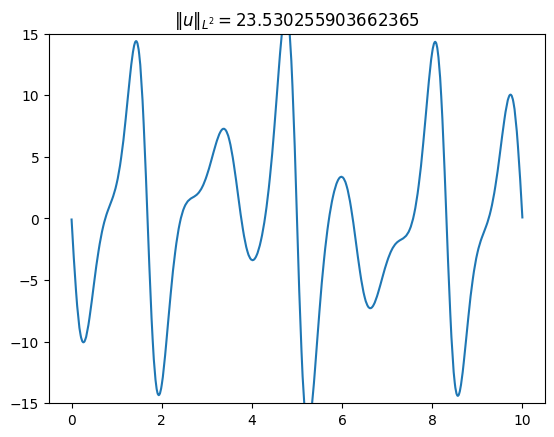

In [5]:
import time
from IPython import display

t=0.
tmax = 10.
tdump = 1.
dumpt = 0.

# file0 = File("stuff.pvd")
VOut = FunctionSpace(mesh, "CG", 3)
uout = Function(VOut)
uout.interpolate(un)
# file0.write(uout)

fig, axes = plt.subplots()
hdisplay = display.display("", display_id=True)

observable = []
t_range = []
integrals = []
while t < tmax - dt/2:
    axes.cla()
    axes.set_ylim([-15, 15])

    t += dt

    KSSolver.solve()
    un.assign(unp1)


    uout.interpolate(un)
    
    curr_norm = norm(un)
    curr_int = assemble(un * dx)
    integrals.append(curr_int)
    observable.append(curr_norm)
    t_range.append(t)
    
    axes.set_title("$\Vert u \Vert_{L^2} = " + f"{curr_norm}$")

    plot(uout, axes=axes)
    hdisplay.update(fig)
    

Text(0, 0.5, 'L2')

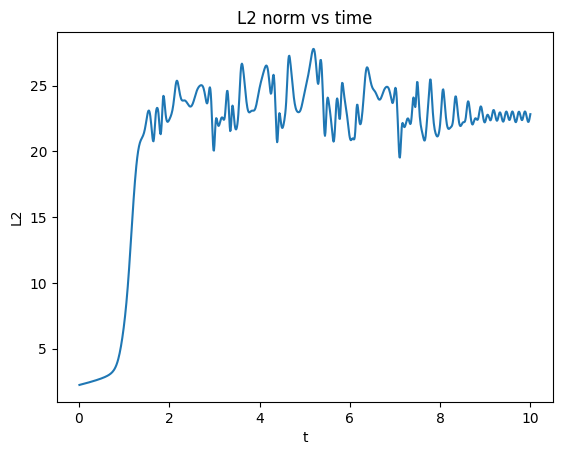

In [6]:
plt.plot(t_range, observable)
plt.title("L2 norm vs time")
plt.xlabel("t")
plt.ylabel("L2")

Text(0.5, 0, 'L2')

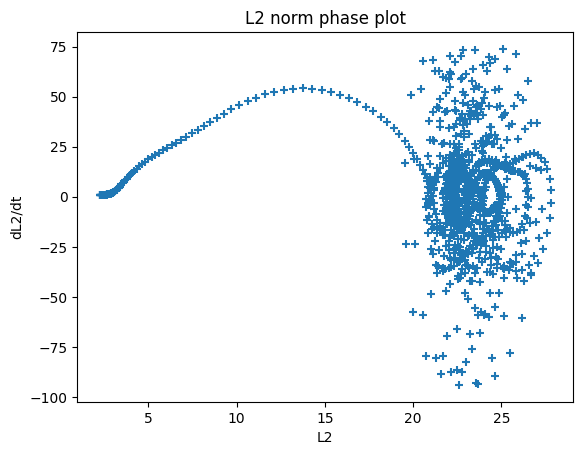

In [7]:

observable = np.array(observable)
dEdt = np.gradient(observable, dt)

plt.scatter(observable, dEdt, marker="+")
plt.title("L2 norm phase plot")
plt.ylabel("dL2/dt")
plt.xlabel("L2")

Text(0, 0.5, '$\\int u(x, t) dx$')

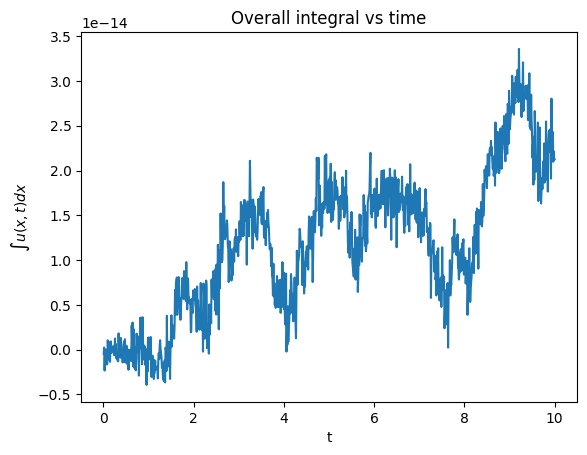

In [8]:
# The error is close to zero
plt.plot(t_range, integrals)
plt.title("Overall integral vs time")
plt.xlabel("t")
plt.ylabel("$\int u(x, t) dx$")


In [4]:

N = 4096
L = 10.
T = 0.5
nu = 0.029
dt = 0.01
samples = 600

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N{N}.h5", "r") as f:
    mesh = f.load_mesh()
    
fs = FunctionSpace(mesh, "HER", 3) 
fs_out = FunctionSpace(mesh, "CG", 3)


data = torch.load(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/samples/N{N}_nu{nu}_T{T}_samples{samples}_batch1.pt")

Text(0.5, 1.0, 'Datapoint 55')

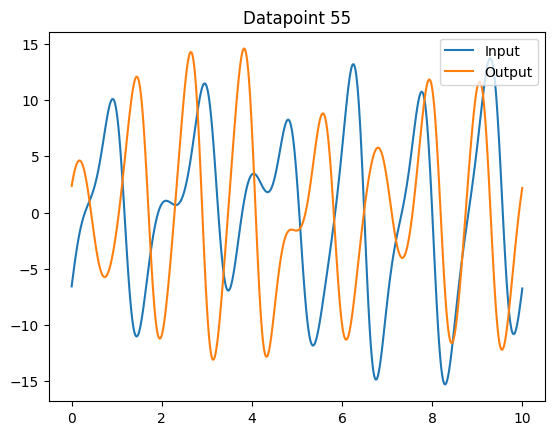

In [7]:
index = 55

func_in_her = Function(fs, val=data[index, 0, :].numpy())
func_out_her = Function(fs, val=data[index, 1, :].numpy())

func_in = Function(fs_out)
func_out = Function(fs_out)

func_in.interpolate(func_in_her)
func_out.interpolate(func_out_her)

fig, axes = plt.subplots()

plot(func_in, axes=axes, label="Input")
plot(func_out, axes=axes, label="Output")
axes.legend()
axes.set_title(f"Datapoint {index}")

In [2]:
from playground.burgers import BurgersDataset
from torch.utils.data.dataloader import DataLoader

device = torch.device("cuda")
N = 4096

samples = torch.load(f"playground/data/KS/samples/N{N}_HER_nu0029_T01_samples1200.pt").unsqueeze(2).to(device=device, dtype=torch.float64)
print(samples.shape)
grid = torch.linspace(0, 1, 2 * N, device=device)
dataset = BurgersDataset(samples, grid)
print(dataset.inputs.shape, dataset.targets.shape)

trainset = torch.tensor(dataset)  # Cutting off the train data
testset = torch.tensor(dataset)

loader = DataLoader(trainset, 32)

torch.Size([1200, 2, 1, 8192])
torch.Size([1200, 2, 1, 8192]) torch.Size([1200, 1, 8192])
torch.Size([1200, 2, 8192]) torch.Size([1200, 1, 8192])


ValueError: only one element tensors can be converted to Python scalars

In [46]:
for x, y in loader:
    print(x.shape, y.shape)

RuntimeError: stack expects each tensor to be equal size, but got [1000, 2, 8192] at entry 0 and [1000, 1, 8192] at entry 1

In [2]:
samples = (torch.load(f"playground/data/burgers/samples/N8192_nu0.01_samples40_batch1.pt")
            .unsqueeze(2).to(device=device, dtype=torch.float64))
grid = torch.linspace(0, 1, 8192, device=device)
dataset = BurgersDataset(samples, grid)
burger_loader = DataLoader(dataset, 32)


FileNotFoundError: [Errno 2] No such file or directory: 'playground/data/burgers/samples/N8192_nu0.01_samples40_batch1.pt'

In [42]:
for x, y in burger_loader:
    print(x.shape, y.shape)

torch.Size([32, 2, 8192]) torch.Size([32, 1, 8192])
torch.Size([8, 2, 8192]) torch.Size([8, 1, 8192])


In [3]:
device = torch.device("cuda")

samples = torch.load(f"data/burgers/samples/N8192_nu0.01_samples40_batch1.pt").unsqueeze(2).to(device=device, dtype=torch.float64)
print(samples.shape)

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N4096.h5", "r") as f:
    mesh1 = f.load_mesh()

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N512.h5", "r") as f:
    mesh2 = f.load_mesh()

torch.Size([40, 2, 1, 8192])


In [9]:
her1 = FunctionSpace(mesh1, "HER", 3)
her2 = FunctionSpace(mesh2, "HER", 3) 
cg1 = FunctionSpace(mesh1, "CG", 3)
cg2 = FunctionSpace(mesh2, "CG", 1)

In [11]:
index = 20
func_her1 = Function(her1, val=samples[index, 0, :].cpu().numpy())
func_her2 = Function(her2)
func_cg2 = Function(cg2)
func_cg1 = Function(cg1)

func_cg1.interpolate(func_her1)
func_cg2.interpolate(func_cg1)
func_her2.project(func_cg2)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fae47c4d810>, FiniteElement('Hermite', interval, 3), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 3)), 188)

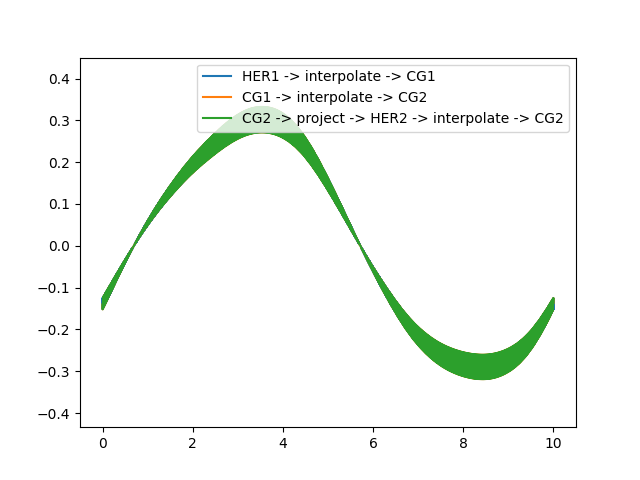

In [6]:
%matplotlib widget

func_cg2_projected = Function(cg2)
func_cg2_projected.interpolate(func_her2)

fig, axes = plt.subplots()
plot(func_cg1, axes=axes, label="HER1 -> interpolate -> CG1")
plot(func_cg2, axes=axes, label="CG1 -> interpolate -> CG2")
plot(func_cg2_projected, axes=axes, label="CG2 -> project -> HER2 -> interpolate -> CG2")
axes.legend()

In [22]:
index = 20
func_her1 = Function(her1, val=samples[index, 0, :].cpu().numpy())
func_cg2 = Function(cg2)
func_cg2.project(func_her1)

NotImplementedError: 
Sorry, only implemented for affine maps for now. To do non-affine, we'd need to
import much more of the assembly engine of UFL/TSFC/etc to do the assembly on
each supermesh cell.


In [51]:
samples1 = torch.load("data/KS/samples/N4096_HER_nu0029_T01_samples1200.pt").unsqueeze(2).to(device=device)
samples2 = torch.load("data/KS/samples/N512_HER_nu0029_T01_samples1200.pt").unsqueeze(2).to(device=device)

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N4096.h5", "r") as f:
    mesh1 = f.load_mesh()

with CheckpointFile(f"/home/clustor2/ma/n/np923/fem_neural_operator/playground/data/KS/meshes/N512.h5", "r") as f:
    mesh2 = f.load_mesh()

In [54]:
her1 = FunctionSpace(mesh1, "HER", 3)
her2 = FunctionSpace(mesh2, "HER", 3) 
cg1 = FunctionSpace(mesh1, "CG", 1)
cg2 = FunctionSpace(mesh2, "CG", 1)

func_her1 = Function(her1, val=samples1[index, 1, :].cpu().numpy())
func_her2 = Function(her2, val=samples2[index, 1, :].cpu().numpy())
func_cg2 = Function(cg2)
func_cg1 = Function(cg1)

func_cg1.interpolate(func_her1)
func_cg2.interpolate(func_her2)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f0ba3caaf50>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1, variant='equispaced'), 160)), 300)

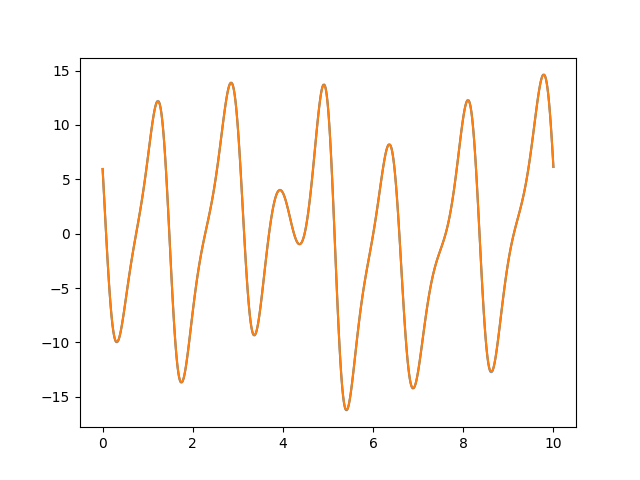

In [55]:
fig, axes = plt.subplots()

plot(func_cg1, axes=axes, label="N4096")
plot(func_cg2, axes=axes, label="N512")